# 04 FEATURE SELECTION AND MACHINE LEARNING (ML)  

## Overview of the Jupyter Notebook

The purpose of the notebook is to apply machine learning classifiers such as LightGBM, CatBoost, and XGBoost and determine if the models can adequately classify a hard drive failure. The hyperparameters were tuned using BayesSearchCV and the results were evaluated using accuracy, F1-score, and F2-score.  

In preparation for the machine learning, label encoding techniques were used to encode the categorical data. Three feature selection techniques including SelectKBest, random forest feature importance, and SelectByShuffling were implemented to create an ensemble of the best features. In addition, random sampling (over and under) was used to address the class imbalance and to make the data manageable for hyperparameter tuning the machine models. A random forest classifer was used to establish a baseline to evaluate the gradient boosted models against. BayeSearchCV was leveraged to identify optimal hyperparamters. The gradient boosted models were implemented with default parameters and tuned parameters and evaluated.  

## Import modules and libraries

In [1]:
import math

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import xgboost as xgb
from catboost import CatBoostClassifier
from feature_engine.selection import SelectByShuffling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             fbeta_score)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV

## Pandas configuration

Pandas default maximum columns is 20. The columns from the data transformation effort is 40.

In [2]:
pd.set_option('display.float_format',  '{:,.2f}'.format)
pd.set_option('display.max_columns', 40)
pd.set_option('display.precision', 2)

## Notebook functions

In [3]:
def non_func_percent(functional, non_functional):
    """
    Accepts a value for functional and non-functional, calculates and 
    returns the non-functional percentage with two decimals.
    
    Keyword arguments:
    functional -- the number of functional hard drive snapshots
    non_functional -- the number of non-functional hard drive snapshots
    """
    non_func_percent = non_functional / (functional + non_functional) \
    * 100
    return round(non_func_percent, 2)

## Import data from Parquet file to dataframe

The data from the prior notebook was previously saved to a Parquet file and is read into a datafame.  

In [4]:
# The 'pq_path' variable is assigned to the path of the Parquet folder 
# ('q1_2022_seagate_eda.parquet').
pq_path = './data/parquet/q1_2022_seagate_eda.parquet'

In [5]:
# References
# https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html
# https://arrow.apache.org/docs/python/generated/pyarrow.parquet.read_table.html

# Pandas allows reading Parquet Files ('read_parquet') directly.
# PyArrow has more options for reading Parquet Files and can be
# passed to a Pandas DataFrame ('q1_2022_seagate_df').
# The Parquet path ('pq_path' is read into a PyArrow Table
# ('q1_2022_seagate_pa_table'). Category columns are defined in a list
# ('categories') and used to read the PyArrow Table
# ('q1_2022_seagate_pa_table') into a Pandas DataFrame 
# ('q1_2022_seagate_df').
# By casting the categories to a 'category' dtype, memory usage was 
# reduced.
q1_2022_seagate_pa_table = pq.read_table(pq_path)
categories = ['serial_number_ltr', 'model', 
              'capacity_terabytes', 'failure']
q1_2022_seagate_df = (
    q1_2022_seagate_pa_table
    .to_pandas(categories=categories, self_destruct=True)
)

The info for the dataframe reveals 9,201,120 rows and 39 columns - 4 columns are `category` and 35 columns are `int64`.  

In [6]:
# Verify the info of the Pandas DataFrame ('q1_2022_seagate_df').
q1_2022_seagate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9201120 entries, 0 to 9201119
Data columns (total 39 columns):
 #   Column                Dtype   
---  ------                -----   
 0   serial_number_ltr     category
 1   model                 category
 2   capacity_terabytes    category
 3   failure               category
 4   smart_1_normalized    int64   
 5   smart_1_raw           int64   
 6   smart_3_normalized    int64   
 7   smart_4_normalized    int64   
 8   smart_4_raw           int64   
 9   smart_5_normalized    int64   
 10  smart_5_raw           int64   
 11  smart_7_normalized    int64   
 12  smart_7_raw           int64   
 13  smart_9_normalized    int64   
 14  smart_9_raw           int64   
 15  smart_10_normalized   int64   
 16  smart_12_normalized   int64   
 17  smart_12_raw          int64   
 18  smart_187_normalized  int64   
 19  smart_187_raw         int64   
 20  smart_188_normalized  int64   
 21  smart_188_raw         int64   
 22  smart_190_normaliz

The first 5 rows are examined to ensure that the data is consistent across all columns.  

In [7]:
q1_2022_seagate_df

,serial_number_ltr,model,capacity_terabytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,S,ST4000DM000,4.00,0,111,41705776,91,100,26,100,0,87,564826045,38,55044,100,100,26,100,0,100,0,73,27,100,3,95,11576,27,27,100,0,100,0,200,0,54939,68556580648,370398316667
1,S,ST4000DM000,4.00,0,118,169130600,97,100,7,100,0,85,390128894,36,56329,100,100,3,100,0,100,0,72,28,100,0,76,49702,28,28,100,0,100,0,200,0,56060,67729811048,409848867140
2,S,ST4000DM000,4.00,0,118,189175216,92,100,12,100,0,83,208738421,34,58422,100,100,11,100,0,100,0,83,17,100,2,93,14304,17,17,100,0,100,0,200,0,58377,69088192984,714479920544
3,S,ST4000DM000,4.00,0,109,21882992,92,100,10,100,0,87,621911450,38,54620,100,100,10,100,0,100,0,84,16,100,0,93,15804,16,16,100,0,100,0,200,0,54564,60854732600,355300153266
4,S,ST4000DM000,4.00,0,117,154406968,92,100,11,100,0,82,187608333,38,54620,100,100,11,100,0,100,0,82,18,100,0,94,12487,18,18,100,0,100,0,200,0,54576,55863048616,338697039483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9201115,Z,ST12000NM001G,12.00,0,80,109909024,99,100,1,100,0,87,487341148,95,5019,100,100,1,100,0,100,0,69,31,100,0,100,211,31,31,100,0,100,0,200,0,4996,33747256368,47906088444
9201116,Z,ST12000NM001G,12.00,0,76,38585856,97,100,3,100,0,84,256187033,97,2939,100,100,3,100,0,100,0,79,21,100,0,100,135,21,21,100,0,100,0,200,0,2921,24066520400,96578036396
9201117,Z,ST10000NM001G,10.00,0,75,32309592,98,100,2,100,0,79,84623606,99,1036,100,100,2,100,0,100,0,74,26,100,0,100,49,26,26,100,0,100,0,200,0,1029,22340154600,14069767910
9201118,Z,ST12000NM001G,12.00,0,76,41882280,99,100,1,100,0,77,46770891,100,407,100,100,1,100,0,100,0,66,34,100,0,100,22,34,34,100,0,100,0,200,0,405,22682193752,5924259866


The ratio for `failure` of `0` or `functional` to `1` or `non-functional` is 3253:1 (9198292/2828). The percentage of `1` or `non-functional` is approximately 0.03%. The data has an extreme class imbalance.  

In [8]:
q1_2022_seagate_df['failure'].value_counts().to_frame('count')

,count
0,9198292
1,2828


In [9]:
round(9198292 / 2828, 0)

3253.0

In [10]:
non_func_percent(9198292, 2828)

0.03

## Label encode the categorical features

Previously, the `serial_number_ltr`, `model`, and `capacity_terabytes` columns were identified as categorical data. To prepare for machine learning, the categorical columns are label encoded. For example, the serial number letter is reassigned from `S` to `0`, model is reassigned from `ST4000DM000` to `9`, and `capacity_terabytes` is reassigned from `4.0` to `1`.  

In [11]:
# References
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

# A LabelEncoder instance ('le') is created. The LabelEncoder instance
# ('le') is used to transform the categorical columns 
# ('serial_number_ltr', 'model', 'capacity_bytes', and 'failure') into 
# labels.
le = LabelEncoder()
q1_2022_seagate_df['serial_number_ltr'] = le.fit_transform(q1_2022_seagate_df['serial_number_ltr'])
q1_2022_seagate_df['model'] = le.fit_transform(q1_2022_seagate_df['model'])
q1_2022_seagate_df['capacity_terabytes'] = le.fit_transform(q1_2022_seagate_df['capacity_terabytes'])
q1_2022_seagate_df['failure'] = le.fit_transform(q1_2022_seagate_df['failure'])

The info for the dataframe reveals 9,201,120 rows and 39 columns - all columns are are `int64`.  

In [12]:
q1_2022_seagate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9201120 entries, 0 to 9201119
Data columns (total 39 columns):
 #   Column                Dtype
---  ------                -----
 0   serial_number_ltr     int64
 1   model                 int64
 2   capacity_terabytes    int64
 3   failure               int64
 4   smart_1_normalized    int64
 5   smart_1_raw           int64
 6   smart_3_normalized    int64
 7   smart_4_normalized    int64
 8   smart_4_raw           int64
 9   smart_5_normalized    int64
 10  smart_5_raw           int64
 11  smart_7_normalized    int64
 12  smart_7_raw           int64
 13  smart_9_normalized    int64
 14  smart_9_raw           int64
 15  smart_10_normalized   int64
 16  smart_12_normalized   int64
 17  smart_12_raw          int64
 18  smart_187_normalized  int64
 19  smart_187_raw         int64
 20  smart_188_normalized  int64
 21  smart_188_raw         int64
 22  smart_190_normalized  int64
 23  smart_190_raw         int64
 24  smart_192_normalized  in

The first 5 rows are examined to ensure that the data is consistent across all columns.  

In [13]:
q1_2022_seagate_df

,serial_number_ltr,model,capacity_terabytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,0,9,1,0,111,41705776,91,100,26,100,0,87,564826045,38,55044,100,100,26,100,0,100,0,73,27,100,3,95,11576,27,27,100,0,100,0,200,0,54939,68556580648,370398316667
1,0,9,1,0,118,169130600,97,100,7,100,0,85,390128894,36,56329,100,100,3,100,0,100,0,72,28,100,0,76,49702,28,28,100,0,100,0,200,0,56060,67729811048,409848867140
2,0,9,1,0,118,189175216,92,100,12,100,0,83,208738421,34,58422,100,100,11,100,0,100,0,83,17,100,2,93,14304,17,17,100,0,100,0,200,0,58377,69088192984,714479920544
3,0,9,1,0,109,21882992,92,100,10,100,0,87,621911450,38,54620,100,100,10,100,0,100,0,84,16,100,0,93,15804,16,16,100,0,100,0,200,0,54564,60854732600,355300153266
4,0,9,1,0,117,154406968,92,100,11,100,0,82,187608333,38,54620,100,100,11,100,0,100,0,82,18,100,0,94,12487,18,18,100,0,100,0,200,0,54576,55863048616,338697039483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9201115,2,4,4,0,80,109909024,99,100,1,100,0,87,487341148,95,5019,100,100,1,100,0,100,0,69,31,100,0,100,211,31,31,100,0,100,0,200,0,4996,33747256368,47906088444
9201116,2,4,4,0,76,38585856,97,100,3,100,0,84,256187033,97,2939,100,100,3,100,0,100,0,79,21,100,0,100,135,21,21,100,0,100,0,200,0,2921,24066520400,96578036396
9201117,2,0,3,0,75,32309592,98,100,2,100,0,79,84623606,99,1036,100,100,2,100,0,100,0,74,26,100,0,100,49,26,26,100,0,100,0,200,0,1029,22340154600,14069767910
9201118,2,4,4,0,76,41882280,99,100,1,100,0,77,46770891,100,407,100,100,1,100,0,100,0,66,34,100,0,100,22,34,34,100,0,100,0,200,0,405,22682193752,5924259866


## Split the data into X and y

The data is split into a `X` matrix and a `y` array, where the `X` matrix contains the features, and `y` array contains the labels (target).  

In [14]:
# The Pandas DataFrame ('q1_2022_seagate_df') is used to split the data
# into an 'X' matrix ('X') and 'y' array ('y').
X = q1_2022_seagate_df.drop(columns='failure')
y = q1_2022_seagate_df['failure']

The `X` matrix only contains the features and no longer contains the `failure` (target).  

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9201120 entries, 0 to 9201119
Data columns (total 38 columns):
 #   Column                Dtype
---  ------                -----
 0   serial_number_ltr     int64
 1   model                 int64
 2   capacity_terabytes    int64
 3   smart_1_normalized    int64
 4   smart_1_raw           int64
 5   smart_3_normalized    int64
 6   smart_4_normalized    int64
 7   smart_4_raw           int64
 8   smart_5_normalized    int64
 9   smart_5_raw           int64
 10  smart_7_normalized    int64
 11  smart_7_raw           int64
 12  smart_9_normalized    int64
 13  smart_9_raw           int64
 14  smart_10_normalized   int64
 15  smart_12_normalized   int64
 16  smart_12_raw          int64
 17  smart_187_normalized  int64
 18  smart_187_raw         int64
 19  smart_188_normalized  int64
 20  smart_188_raw         int64
 21  smart_190_normalized  int64
 22  smart_190_raw         int64
 23  smart_192_normalized  int64
 24  smart_192_raw         in

The first 5 rows of the `X` matrix are examined to ensure that the data is consistent across all columns.  

In [16]:
X.head(5)

,serial_number_ltr,model,capacity_terabytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,0,9,1,111,41705776,91,100,26,100,0,87,564826045,38,55044,100,100,26,100,0,100,0,73,27,100,3,95,11576,27,27,100,0,100,0,200,0,54939,68556580648,370398316667
1,0,9,1,118,169130600,97,100,7,100,0,85,390128894,36,56329,100,100,3,100,0,100,0,72,28,100,0,76,49702,28,28,100,0,100,0,200,0,56060,67729811048,409848867140
2,0,9,1,118,189175216,92,100,12,100,0,83,208738421,34,58422,100,100,11,100,0,100,0,83,17,100,2,93,14304,17,17,100,0,100,0,200,0,58377,69088192984,714479920544
3,0,9,1,109,21882992,92,100,10,100,0,87,621911450,38,54620,100,100,10,100,0,100,0,84,16,100,0,93,15804,16,16,100,0,100,0,200,0,54564,60854732600,355300153266
4,0,9,1,117,154406968,92,100,11,100,0,82,187608333,38,54620,100,100,11,100,0,100,0,82,18,100,0,94,12487,18,18,100,0,100,0,200,0,54576,55863048616,338697039483


The `y` array only contains the `failure` (target) and does not include the features.  

In [17]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 9201120 entries, 0 to 9201119
Series name: failure
Non-Null Count    Dtype
--------------    -----
9201120 non-null  int64
dtypes: int64(1)
memory usage: 70.2 MB


The first 5 values of the `y` array are examined.  

In [18]:
y[0:5]

0    0
1    0
2    0
3    0
4    0
Name: failure, dtype: int64

The `y` or label contains 9,198,292 `0` or `functional` and 2,828 `1` or `non-functional` hard drive snapshots.  

In [19]:
y.value_counts().to_frame('count')

,count
0,9198292
1,2828


The ratio for `failure` of `0` or `functional` to `1` or `non-functional` is 3253:1 (9198292/2828); very highly imbalanced data. However, the percentage of `1` or `non-functional` remains at approximately 0.03%.  

In [20]:
round(9198292 / 2828, 0)

3253.0

In [21]:
non_func_percent(9198292, 2828)

0.03

## Split the data into train and test  

The data is further split into `train` and `test`. The `train` data will be used to train and the `test` data will be used to validate the model on unseen data.  

In [22]:
# An 'X' matrix ('X') and 'y' array ('y') are split into train and test 
# datasets.
# The train size is 80% and the test size is 20%.
# A random state of '42' is used for reproducibility and stratify is
# implemented to ensure observations from both classes.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y)

In [23]:
print("X train data size:", X_train.shape)
print("y train data size:", y_train.shape)
print("X test data size:", X_test.shape)
print("y test data size:", y_test.shape)

X train data size: (7360896, 38)
y train data size: (7360896,)
X test data size: (1840224, 38)
y test data size: (1840224,)


Confirmed that the `X_train` matrix only contains the features and does not include the `failure` (target).  

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7360896 entries, 2722206 to 3860611
Data columns (total 38 columns):
 #   Column                Dtype
---  ------                -----
 0   serial_number_ltr     int64
 1   model                 int64
 2   capacity_terabytes    int64
 3   smart_1_normalized    int64
 4   smart_1_raw           int64
 5   smart_3_normalized    int64
 6   smart_4_normalized    int64
 7   smart_4_raw           int64
 8   smart_5_normalized    int64
 9   smart_5_raw           int64
 10  smart_7_normalized    int64
 11  smart_7_raw           int64
 12  smart_9_normalized    int64
 13  smart_9_raw           int64
 14  smart_10_normalized   int64
 15  smart_12_normalized   int64
 16  smart_12_raw          int64
 17  smart_187_normalized  int64
 18  smart_187_raw         int64
 19  smart_188_normalized  int64
 20  smart_188_raw         int64
 21  smart_190_normalized  int64
 22  smart_190_raw         int64
 23  smart_192_normalized  int64
 24  smart_192_raw     

The first 5 rows of the `X_train` matrix are examined to ensure that the data is consistent across all columns.  

In [25]:
X_train.head(5)

,serial_number_ltr,model,capacity_terabytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
2722206,2,6,5,83,180931624,98,100,2,100,0,89,726114280,87,11761,100,100,2,100,0,100,0,74,26,100,1,100,1252,26,26,100,0,100,0,200,0,11388,76514038152,161704380238
5676868,2,4,4,83,211399344,95,100,4,100,0,83,206632265,87,11591,100,100,4,100,0,100,0,67,33,100,1,100,577,33,33,100,0,100,0,200,0,11513,31146046360,143873766603
1723803,2,9,1,108,16463440,91,100,16,100,0,87,569292162,31,60859,100,100,16,100,0,100,0,83,17,100,1,75,51054,17,17,100,0,100,0,200,0,60681,73971752752,329766916753
5244666,2,8,6,82,172972960,99,100,1,100,0,89,798533845,93,6844,100,100,1,100,0,100,0,65,35,100,0,99,3278,35,35,100,0,100,0,200,0,6131,47949673480,80155030470
3373051,2,13,2,83,192023560,89,100,17,100,0,90,1112929470,55,39499,100,100,17,100,0,100,0,65,35,100,70,87,26224,35,35,100,0,100,0,200,0,39462,71222080016,490472017990


The `y_train` array only contains the `failure` (target) and does not include the features.  

In [26]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 7360896 entries, 2722206 to 3860611
Series name: failure
Non-Null Count    Dtype
--------------    -----
7360896 non-null  int64
dtypes: int64(1)
memory usage: 112.3 MB


The first 5 values of the `y_train` array are examined.  

In [27]:
y_train[0:5]

2722206    0
5676868    0
1723803    0
5244666    0
3373051    0
Name: failure, dtype: int64

The ratio for `failure` of `0` or `functional` to `1` or `non-functional` is 3253:1 (9198292/2828); very highly imbalanced data. However, the percentage of `1` or `non-functional` remains at approximately 0.03%.  

In [28]:
y_train.value_counts().to_frame('count')

,count
0,7358634
1,2262


The `y_train` or label contains 9,198,292 `0` or `functional` and 2,828 `1` or `non-functional` hard drive snapshots.  

In [29]:
round(7358634 / 2262, 0)

3253.0

In [30]:
non_func_percent(7358634, 2262)

0.03

Confirmed that the `X_test` matrix only contains the features and does not include the `failure` (target).  

In [31]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1840224 entries, 7820082 to 1072440
Data columns (total 38 columns):
 #   Column                Dtype
---  ------                -----
 0   serial_number_ltr     int64
 1   model                 int64
 2   capacity_terabytes    int64
 3   smart_1_normalized    int64
 4   smart_1_raw           int64
 5   smart_3_normalized    int64
 6   smart_4_normalized    int64
 7   smart_4_raw           int64
 8   smart_5_normalized    int64
 9   smart_5_raw           int64
 10  smart_7_normalized    int64
 11  smart_7_raw           int64
 12  smart_9_normalized    int64
 13  smart_9_raw           int64
 14  smart_10_normalized   int64
 15  smart_12_normalized   int64
 16  smart_12_raw          int64
 17  smart_187_normalized  int64
 18  smart_187_raw         int64
 19  smart_188_normalized  int64
 20  smart_188_raw         int64
 21  smart_190_normalized  int64
 22  smart_190_raw         int64
 23  smart_192_normalized  int64
 24  smart_192_raw     

The `X_train` matrix has consistency in the columns.  

In [32]:
X_test.head(5)

,serial_number_ltr,model,capacity_terabytes,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,smart_7_normalized,smart_7_raw,smart_9_normalized,smart_9_raw,smart_10_normalized,smart_12_normalized,smart_12_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_190_normalized,smart_190_raw,smart_192_normalized,smart_192_raw,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
7820082,2,3,4,83,178205160,92,100,9,100,0,86,407826516,85,13827,100,100,9,100,0,100,0,76,24,100,5,100,837,24,24,100,0,100,0,200,0,13670,29616358984,169050885282
2411402,2,4,4,76,44248952,90,100,8,100,0,82,147180056,84,14065,100,100,7,100,0,100,0,72,28,100,2,100,776,28,28,100,0,100,0,200,0,13937,72202983584,218369147298
1447606,2,13,2,80,95724744,89,100,9,100,0,94,2482586872,52,42534,100,100,9,100,0,100,0,63,37,100,7,72,57540,37,37,100,0,100,0,200,0,42495,84348667512,352664327748
3187839,2,3,4,81,132344880,94,100,5,100,0,83,214596619,82,16345,100,100,5,100,0,100,0,67,33,100,0,100,917,33,33,100,0,100,0,200,0,16219,76959572328,201737685252
1214877,0,9,1,119,221044016,94,100,6,100,0,84,237379309,34,57939,100,100,6,100,0,100,1,73,27,100,0,25,151514,27,27,100,0,100,0,200,0,57242,65140893744,379203008724


The `y_test` array only contains the `failure` (target) and does not include the features.  

In [33]:
y_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 1840224 entries, 7820082 to 1072440
Series name: failure
Non-Null Count    Dtype
--------------    -----
1840224 non-null  int64
dtypes: int64(1)
memory usage: 28.1 MB


The first 5 values of the `y_test` array are examined.  

In [34]:
y_test[0:5]

7820082    0
2411402    0
1447606    0
3187839    0
1214877    0
Name: failure, dtype: int64

The ratio for `failure` of `0` or `functional` to `1` or `non-functional` remains at 3250:1 (1839658/566) and the percentage of `1` or `non-functional` remains at approximately 0.03%.  

In [35]:
y_test.value_counts().to_frame('count')

,count
0,1839658
1,566


The ratio for `failure` of `0` or `functional` to `1` or `non-functional` is 3250:1 (1839658/566); very highly imbalanced data. However, the percentage of `1` or `non-functional` remains at approximately 0.03%.  

In [36]:
round(1839658 / 566, 0)

3250.0

In [37]:
non_func_percent(1839658, 566)

0.03

## Random sampling (over and under)  

The `X_train` and `y_train` data consists of 7,360,896 rows, which is a substantial amount of data. The size of data can present challenges for maching learning. Using random over-sampling and random under-sampling provides a subset of data, which allows for faster processing of data.  

To obtain an optimal sample size, the `1` or `non-functional` (minority class) is oversampled by 10%. Next, the `0` or o`functional` (majority class) is undersampled to match the `1` or `non-functional` (minority class).  

In [38]:
# References
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

# The minority class ('non-functional' or 1) is over-sampled by a ratio 
# (0.1) to increase the quantity of samples in the minority class 
# ('non-functional' or 1).
ros = RandomOverSampler(
    sampling_strategy=0.1, 
    random_state=42
)
X_train_ros, y_train_ros = ros.fit_resample(
    X_train, 
    y_train
)

The minority class is now 10% of the majority class.  

In [39]:
(
    y_train_ros
    .value_counts()
    .to_frame('count')
)

,count
0,7358634
1,735863


In [40]:
# References
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

# The majority class ('functional' or 0) is under-sampled by a strategy 
# of 'all' to decrease the quantity of samples in the majority class 
# ('functional' or 0) to equal the minority class ('non-functional' or
# 1).
rus = RandomUnderSampler(
    sampling_strategy='all', 
    random_state=42
)
X_train_res, y_train_res = rus.fit_resample(
    X_train_ros, 
    y_train_ros
)

In [41]:
print("X train data resampled size:", 
      X_train_res.shape)
print("y train data resampled size:", 
      y_train_res.shape)

X train data resampled size: (1471726, 38)
y train data resampled size: (1471726,)


The data is now balanced for both classes.  

In [42]:
(
    y_train_res.value_counts()
    .to_frame('count')
)

,count
0,735863
1,735863


## Feature selection  

Three techniques are utilized to select features - SelectKBest, random forest classifier feature importance, and SelectByShuffling. 

### SelectKBest feature selection  

In [43]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

# SelectKBest feature selection is used with the Chi-squared stats
# ('chi2') scoring function and k (all) top features.
# The SelectKBest object ('skb_chi2_sample') is created and 
# fit/transform is applied on the 'X_train' and 'y_train' data.
skb_chi2_sample = SelectKBest(score_func=chi2, k='all')
skb_chi2_sample.fit_transform(X_train, y_train)

array([[           2,            6,            5, ...,        11388,
         76514038152, 161704380238],
       [           2,            4,            4, ...,        11513,
         31146046360, 143873766603],
       [           2,            9,            1, ...,        60681,
         73971752752, 329766916753],
       ...,
       [           2,            9,            1, ...,        55133,
         70948229968, 320173877611],
       [           2,           13,            2, ...,        39427,
         78992277128, 324068519246],
       [           2,            9,            1, ...,        52727,
         63558549688, 321868523565]])

In [44]:
# A Pandas DataFrame is displayed using the 'X train' columns and 
# the SelectKBest object ('skb_chi2_sample') scores.
# The Pandas DataFrame is sorted by the 'scores' in descending order 
# and the top 10 results are returned.
(
    pd.DataFrame(zip(X_train.columns, 
                     pd.Series(skb_chi2_sample.scores_)), 
                 columns=['feature', 'scores'])
    .sort_values('scores', ascending=False)
    .reset_index(drop=True)
    .head(10)
)

,feature,scores
0,smart_7_raw,"41,094,649,613,218.91"
1,smart_242_raw,"37,045,446,467,642.90"
2,smart_188_raw,"14,527,857,417,944.73"
3,smart_241_raw,"1,643,146,073,203.87"
4,smart_199_raw,"47,605,722,102.03"
5,smart_5_raw,"1,171,595,390.02"
6,smart_197_raw,"193,369,861.95"
7,smart_198_raw,"193,369,861.95"
8,smart_187_raw,"180,528,158.61"
9,smart_1_raw,"11,661,749.95"


### Random forest feature importance  

A random forest classifier estimator needs to be created and fitted on the train data to calculate the feature importance. Due to the complex computations, the resampled data is used.  

In [45]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# A random forest classifier ('rfc_fs_res') is created using the number 
# of jobs ('n_jobs') set to '14', so that the CPUs are not over 
# utilized. The random state of '42' is set for reproducibility.
rfc_fs_res = RandomForestClassifier(
    n_jobs=14, 
    random_state=42
)

In [46]:
# A random forest classifier ('rfc_fs_res') is fitted on the 'X_train' 
# 'y_train' resampled data.
rfc_fs_res.fit(
    X_train_res, 
    y_train_res
)

RandomForestClassifier(n_jobs=14, random_state=42)

The feature importances from the random forest classifier are obtained.  

In [47]:
# A Pandas DataFrame is created with the 'X_train' resampled data
# columns and the feature importances from the random forest classifier
# model ('rfc_fs_res'). The 'importance' values are sorted in
# descending order and only the first 10 features are displayed.
(
    pd.DataFrame(zip(X_train_res.columns, 
                     rfc_fs_res.feature_importances_), 
                 columns=['feature', 'importance'])
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
    .head(10)
)

,feature,importance
0,smart_187_raw,0.14
1,smart_187_normalized,0.13
2,smart_5_raw,0.13
3,smart_197_raw,0.05
4,smart_193_raw,0.04
5,smart_241_raw,0.04
6,smart_242_raw,0.04
7,smart_198_raw,0.04
8,smart_9_raw,0.04
9,smart_7_raw,0.04


### Select by shuffle feature elimination  

Select by shuffle uses the random forest classifier estimator and as the features are shuffled, evaluates for a performance drop (Feature-engine developers, 2022). If the feature drop is greater than the threshold of 0.01, the feature is dropped (Feature-engine developers, 2022). Due to the complex computations, the resampled data is used.  

In [48]:
# References
# https://feature-engine.readthedocs.io/en/latest/api_doc/selection/SelectByShuffling.html

# Select by shuffle uses the random forest classifier estimator and
# randomly checks the model performance drop by shuffling the features.
selectbyshuffle_fs = SelectByShuffling(
    rfc_fs_res, 
    scoring='f1', 
    cv=3, 
    random_state=42
)

In [49]:
# The SelectByShuffling object ('selectbyshuffle_fs') is fitted on the
# 'X_train' and 'y_train' resampled data.
selectbyshuffle_fs.fit(
    X_train_res, 
    y_train_res
)

SelectByShuffling(estimator=RandomForestClassifier(n_jobs=14, random_state=42),
                  random_state=42, scoring='f1')

In [50]:
# The features of importances are obtained by from the 
# SelectByShuffling object ('selectbyshuffle_fs').  
selectbyshuffle_fs.get_feature_names_out()

['smart_5_raw',
 'smart_7_raw',
 'smart_9_raw',
 'smart_187_normalized',
 'smart_187_raw',
 'smart_192_raw',
 'smart_193_raw',
 'smart_197_raw',
 'smart_198_raw',
 'smart_240_raw',
 'smart_241_raw',
 'smart_242_raw']

***

## Select the new features  

The features are selected that appeared 2 or more times in the feature selection methods, with the exception of `smart_188_raw` feature. The `smart_188_raw` feature only appeared in 1 feature selection method. However, the `smart_188_raw` feature is being included due to possibly being critical in predicting hard drive failure (S.M.A.R.T., 2022). The feature is being included due to domain knowledge.  
<br>

| ATTRIBUTE             | ATTRIBUTE NAME                                |
|-----------------------|-----------------------------------------------|
|     smart_5_raw       |     Reallocated Sectors Count                 |
|     smart_7_raw       |     Seek Error Rate                           |
|     smart_9_raw       |     Power-On Hours                            |
|     smart_187_raw     |     Reported Uncorrectable Errors             |
|     smart_188_raw*    |     Command Timeout                           |
|     smart_193_raw     |     Load Cycle Count                          |
|     smart_197_raw     |     Current Pending Sector Count              |
|     smart_198_raw     |     (Offline) Uncorrectable Sector Count      |
|     smart_240_raw     |     Head Flying Hours                         |
|     smart_241_raw     |     Total LBAs Written                        |
|     smart_242_raw     |     Total LBAs Read                           |

(S.M.A.R.T., 2022)  

In [51]:
# A new Pandas DataFrame ('q1_2022_seagate_feat_df') is created with 
# the new features that are selected.
features = ['smart_5_raw', 'smart_7_raw', 'smart_9_raw', 
            'smart_187_raw', 'smart_188_raw', 'smart_193_raw', 
            'smart_197_raw', 'smart_198_raw', 'smart_240_raw', 
            'smart_241_raw', 'smart_242_raw', 'failure']
q1_2022_seagate_feat_df = q1_2022_seagate_df[features]
q1_2022_seagate_feat_df.columns

Index(['smart_5_raw', 'smart_7_raw', 'smart_9_raw', 'smart_187_raw',
       'smart_188_raw', 'smart_193_raw', 'smart_197_raw', 'smart_198_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'failure'],
      dtype='object')

## Split the data into X and y with the new features

The data with the new features is split into a `X` matrix and a `y` array, where the `X` matrix contains the features, and `y` array contains the labels (target).  

In [52]:
# The Pandas DataFrame ('q1_2022_seagate_df') is used to split the 
# data into an 'X' matrix ('X_feat') and 'y' array ('y_feat').
X_feat = q1_2022_seagate_feat_df.drop(columns='failure')
y_feat = q1_2022_seagate_feat_df['failure']

The `X` matrix only contains the `smart` features and no longer contains the `failure` (target).  

In [53]:
X_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9201120 entries, 0 to 9201119
Data columns (total 11 columns):
 #   Column         Dtype
---  ------         -----
 0   smart_5_raw    int64
 1   smart_7_raw    int64
 2   smart_9_raw    int64
 3   smart_187_raw  int64
 4   smart_188_raw  int64
 5   smart_193_raw  int64
 6   smart_197_raw  int64
 7   smart_198_raw  int64
 8   smart_240_raw  int64
 9   smart_241_raw  int64
 10  smart_242_raw  int64
dtypes: int64(11)
memory usage: 772.2 MB


The `y` array only contains the `failure` (target).  

In [54]:
y_feat.info()

<class 'pandas.core.series.Series'>
RangeIndex: 9201120 entries, 0 to 9201119
Series name: failure
Non-Null Count    Dtype
--------------    -----
9201120 non-null  int64
dtypes: int64(1)
memory usage: 70.2 MB


## Split the data into train and test with the new features

In [55]:
# An 'X' matrix ('X_feat') and 'y' array ('y_feature') are split into 
# train and test datasets.
# The train size is 80% and the test size is 20%.
# A random state of '42' is used for reproducibility and stratify is
# implemented to ensure observations from both classes.
X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_feat, y_feat, 
    test_size=0.20, 
    random_state=42, 
    stratify=y)

In [56]:
print("X train data size with new features: ", X_train_feat.shape)
print("y train data size with new features: ", X_test_feat.shape)
print("X test data size with new features: ", y_train_feat.shape)
print("y test data size with new features:", y_test_feat.shape)

X train data size with new features:  (7360896, 11)
y train data size with new features:  (1840224, 11)
X test data size with new features:  (7360896,)
y test data size with new features: (1840224,)


## Random sampling (over and under) new features  

Once the new features are selected, random over-sampling and random under-sampling needs to be applied to the to data reduce the size. The reduced data is used for finding the best parameters with BayesSearchCV for the machine learning models.  Using random over-sampling and random under-sampling provides a subset of data, which allows for faster processing of data.  

In [57]:
# References
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html

# The minority class ('non-functional' or 1) is over-sampled by 10% 
# (0.1) to increase the quantity of samples in the minority class 
# ('non-functional' or 1).
ros = RandomOverSampler(
    sampling_strategy=0.1, 
    random_state=42
)
X_train_ros_feat, y_train_ros_feat = ros.fit_resample(
    X_train_feat, 
    y_train_feat
)

In [58]:
# References
# https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

# The majority class ('functional' or 0) is under-sampled by a strategy 
# of 'all' to decrease the quantity of samples in the majority class 
# ('functional' or 0) to equal the minority class ('non-functional' or
# 1).
rus = RandomUnderSampler(
    random_state=42
)
X_train_res_feat, y_train_res_feat = rus.fit_resample(
    X_train_ros_feat, 
    y_train_ros_feat
) 

In [59]:
print("X train data resampled size with new features:", 
      X_train_res_feat.shape)
print("y train data resampled size with new features:", 
      y_train_res_feat.shape)

X train data resampled size with new features: (1471726, 11)
y train data resampled size with new features: (1471726,)


The data is now balanced for both classes.  

In [60]:
y_train_res_feat.value_counts().to_frame('count')

,count
0,735863
1,735863


## Random forest classifier baseline

A random forest classifier was previously established for feature selection. However, the random classifier used resampled data. For a baseline to compare other gradient boosted models, a random forest classifier model is run on the full data. The gradient boosted models will be measured against the F1 and F2 scores.  

In [61]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# A random forest classifier ('rfc_feat') is created using the number
# of jobs ('n_jobs') set to '14', so that the CPUs are not over 
# utilized. The random state of '42' is set for reproducibility.
rfc_feat = RandomForestClassifier(
    n_jobs=14,
    random_state=42
)

In [62]:
# Display the parameters for the random forest classifier object 
# ('rfc_feat').
rfc_feat.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 14,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [63]:
# A random forest classifier ('rfc_feat') is fitted on the 'X_train' 
# and 'y_train' data with the new features.
rfc_feat.fit(
    X_train_feat, 
    y_train_feat
)

RandomForestClassifier(n_jobs=14, random_state=42)

In [64]:
# Predict is called on the 'X_test' data with the new features.
y_pred_rfc_feat = rfc_feat.predict(X_test_feat)

In [65]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# Scores are printed for accuracy, F1-score, and F2-score.
print("RandomForestClassifier resampled performance:")
print(f"Accuracy score: {accuracy_score(y_test_feat, y_pred_rfc_feat):.3f}")
print(f"F1 score: {f1_score(y_test_feat, y_pred_rfc_feat):.3f}")
print(f"F2 score: {fbeta_score(y_test_feat, y_pred_rfc_feat, average='binary', beta=2.0):.3f}")

RandomForestClassifier resampled performance:
Accuracy score: 1.000
F1 score: 0.727
F2 score: 0.635


In [66]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# A confusion matrix is created from the 'y_test' label data and the 
# 'y_pred' predicted labels with the new features.
print("RandomForestClassifier best model confusion matrix: ")
print(confusion_matrix(y_test_feat, y_pred_rfc_feat))

RandomForestClassifier best model confusion matrix: 
[[1839645      13]
 [    235     331]]


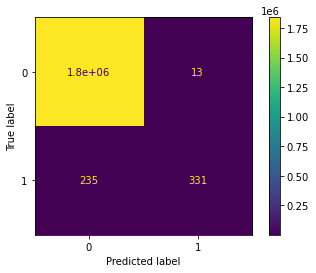

In [67]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# A graphical confusion matrix is displayed from the 'y_test' label 
# data and the 'y_pred' predicted labels with the new features. 
cm = confusion_matrix(y_test_feat, y_pred_rfc_feat, 
                      labels=rfc_feat.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=rfc_feat.classes_)
disp_cm.plot()
plt.show()

Perhaps, an easier way to interpret the confusion matrix is explicitly printing out the true negative (`tn`), false negative, (`fn`), true positive (`tp`), and false positive (`fp`) values. The results indicate that the random forest model predicted 1,839,640 true negative (accurately classified as `functional`), 209 false negative (inaccurately classified as `functional`), 357 true positive (accurately classified as `non-functional`), and 18 false positive (inaccurately classified as `non-functional`).  

In [68]:
# References
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

# To provide an explicit count for true negative ('tn'), false negative
# ('fn'), true positive ('tp'), and false positive ('fp') values, the 
# confusion matrix ('cm') is sliced and the values are printed.
tn = cm[0][0]
print("True negative: ", tn)
fn = cm[1][0]
print("False negative: ", fn)
tp = cm[1][1]
print("True positive: ", tp)
fp = cm[0][1]
print("False positive: ", fp)

True negative:  1839645
False negative:  235
True positive:  331
False positive:  13


The classification report for random forest classifer with default parameters indicate that the precision is higher at 0.95 compared to the recall at 0.63. The random forest classifier model is slightly better at precision.  

In [69]:
target_names = ['functional', 'non-functional']
print("RandomForestClassifier default classification report:")
print(classification_report(y_test_feat, y_pred_rfc_feat, 
                            target_names=target_names))

RandomForestClassifier default classification report:
                precision    recall  f1-score   support

    functional       1.00      1.00      1.00   1839658
non-functional       0.96      0.58      0.73       566

      accuracy                           1.00   1840224
     macro avg       0.98      0.79      0.86   1840224
  weighted avg       1.00      1.00      1.00   1840224



***

## Control the balance of positive and negative weights

As previously observed, there is an extreme class imbalance in the data.  

The negative class (`0` or `functional`) is 9,198,292 and the positive class (`1` or `non-functional`) is 2,828.  

In [70]:
(
    q1_2022_seagate_feat_df[['failure']]
    .value_counts()
    .to_frame('count')
)

,count
failure,
0,9198292
1,2828


The gradient boosted models offer a `scale_pos_weight` parameter which provides a weight to the positive class and is used to control the class imbalance (Mehta, 2017).  

The following calculation can be used to adjust for the extreme class imbalance (Deltascience, 2019):  

`scale_pos_weight = sqrt(count(negative examples)/count(positive examples))`

In [71]:
neg = q1_2022_seagate_feat_df[['failure']].value_counts().values[0]
pos = q1_2022_seagate_feat_df[['failure']].value_counts().values[1]
scale_pos_weight = round(math.sqrt(neg / pos), 1)
scale_pos_weight

57.0

The `scale_pos_weight` parameter will be applied to the best parameters to fit the model.  

## LightGBM classifier  

### Default

A LightGBM classifier model is created with default parameters to determine the performance by evaluating F1 and F2 scores.  

In [72]:
# References
# https://lightgbm.readthedocs.io/en/v3.3.2/Python-API.html

# A LightGBM classifier ('LGBMClassifier') estimator is created
# random state of '42'.  LGBMClassifier does not have a evaluation 
# metric for 'F1'. The 'F1' score will be evaluated during 
# BayesSearchCV. All other parameters are default.
lgbc = lgb.LGBMClassifier(
    n_jobs=14,
    random_state=42
)

The LightGBM classifier estimator with the default parameters are fit on the `X_train` and `y_train` data with the selected features.  

In [73]:
# The LightGBM classifier ('LGBMClassifier') estimator is fitted on
# the 'X_train' and 'y_train' data with the selected features.
lgbc.fit(X_train_feat, y_train_feat)

LGBMClassifier(n_jobs=14, random_state=42)

The LightGBM classifier model predicts on the `X_test` data with the select features.  

In [74]:
# Predict is called on the 'X_test' data with the selected features.
y_pred_lgbc = lgbc.predict(X_test_feat)

In [75]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# Scores are printed for accuracy, F1-score, and F2-score.
print("LGBMClassifier default parameters performance:")
print(f"Accuracy score: {accuracy_score(y_test_feat, y_pred_lgbc):.3f}")
print(f"F1 score: {f1_score(y_test_feat, y_pred_lgbc):.3f}")
print(f"F2 score: {fbeta_score(y_test_feat, y_pred_lgbc, average='binary', beta=2.0):.3f}")

LGBMClassifier default parameters performance:
Accuracy score: 1.000
F1 score: 0.240
F2 score: 0.236


### Parameter grid  

In an effort to improve the F1 and F2 scores, a grid is created with various parameters to search through to find the optimal parameters.  

In [76]:
# The LightGBM classifier ('LGBMClassifier') estimator ('lgbc_tune') 
# is created for tuning.
lgbc_tune = lgb.LGBMClassifier()

In [77]:
# The parameters of the LightGBM classifier estimator ('lgbc_tune') are 
# displayed.
lgbc_tune.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [78]:
# References
# https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
# # https://towardsdatascience.com/catboost-vs-lightgbm-vs-xgboost-c80f40662924

# A paramter grid ('lgbc_param_grid') to search for the best parameters 
# for the LightGBM classifier estimator ('lgbc_tune') is created.
lgbc_param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [100, 500, 1000],   
    'random_state' : [42],
    'n_jobs': [14],
}

### BayesSearchCV

Using BayesSearchCV with RepeatedStratifiedKFold the parameters are searched and evaluated to find the best parameters.  

In [79]:
# References
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

# A BayesSearchCV object ('lgbc_opt') is created to search the 
# parameter grid ('lgbc_param_grid') for the best parameters with the 
# LightGBM classifier estimator ('lgbc_tune'). The scoring is set to 
# 'f1', '5' parameter samples, '1' number of jobs, and a random state 
# of '42'. (Stratified)KFold of 3 is used for cross-validation.
lgbc_opt = (
    BayesSearchCV(
        lgbc_tune, lgbc_param_grid, n_iter=5, 
        scoring='f1', n_jobs=1, refit=True, 
        cv=3, random_state=42)
)

In [80]:
# The parameters of the BayesSearchCV object ('lgbc_opt') are 
# displayed.
lgbc_opt.get_params()

{'cv': 3,
 'error_score': 'raise',
 'estimator__boosting_type': 'gbdt',
 'estimator__class_weight': None,
 'estimator__colsample_bytree': 1.0,
 'estimator__importance_type': 'split',
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': -1,
 'estimator__min_child_samples': 20,
 'estimator__min_child_weight': 0.001,
 'estimator__min_split_gain': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': -1,
 'estimator__num_leaves': 31,
 'estimator__objective': None,
 'estimator__random_state': None,
 'estimator__reg_alpha': 0.0,
 'estimator__reg_lambda': 0.0,
 'estimator__silent': 'warn',
 'estimator__subsample': 1.0,
 'estimator__subsample_for_bin': 200000,
 'estimator__subsample_freq': 0,
 'estimator': LGBMClassifier(),
 'fit_params': None,
 'iid': 'deprecated',
 'n_iter': 5,
 'n_jobs': 1,
 'n_points': 1,
 'optimizer_kwargs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': 42,
 'refit': True,
 'return_train_score': False,
 'scoring': 'f1',
 'search_spaces': {'max_depth': [3

The BayesSearchCV is implemented with the LightGBM classifier estimator and fit on the `X_train` and `y_train` data with the selected features to search for the best parameters.  

In [81]:
# The BayesSearchCV object ('lgbc_opt') is fitted on the 'X_train' and 
# 'y_train' resampled data with the selected features.
lgbc_opt.fit(
    X_train_res_feat, 
    y_train_res_feat
)

BayesSearchCV(cv=3, estimator=LGBMClassifier(), n_iter=5, random_state=42,
              scoring='f1',
              search_spaces={'learning_rate': [0.1, 0.3, 0.5],
                             'max_depth': [3, 6, 9],
                             'n_estimators': [100, 500, 1000], 'n_jobs': [14],
                             'random_state': [42]})

In [82]:
# Best estimator, best score, and best parameters are printed.
print("LGBMClassifier BayesSearchCV results: " )
print("Best estimator: ", lgbc_opt.best_estimator_)
print("Best score: ", lgbc_opt.best_score_)
print("Best parameters: ", lgbc_opt.best_params_)

LGBMClassifier BayesSearchCV results: 
Best estimator:  LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=1000, n_jobs=14,
               random_state=42)
Best score:  0.9996393300965559
Best parameters:  OrderedDict([('learning_rate', 0.3), ('max_depth', 6), ('n_estimators', 1000), ('n_jobs', 14), ('random_state', 42)])


### Best estimator

The best parameters from the BayesSearchCV parameter search are used to create a LightGBM classifier estimator.  

In [83]:
# The LightGBM classifier ('LGBMClassifier') estimator ('lgbc_best') 
# is created using the best parameters. 
# The 'scale_pos_weight' parameter is added due to the extreme class
# imbalance.  
lgbc_best = lgb.LGBMClassifier(
    learning_rate=0.3,
    max_depth=6,
    n_estimators=1000,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

In [84]:
# The parameters of the LightGBM classifier ('LGBMClassifier') 
# estimator ('lgbc_best') are displayed.
lgbc_best.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'scale_pos_weight': 57.0}

### Fit and predict with best estimator  

The LightGBM classifier estimator with the best parameters from the BayesSearchCV parameter search are fit on the `X_train` and `y_train` data with the selected features.  

In [85]:
# The best parameters are utilized with LightGBM classifier 
# ('LGBMClassifier') estimator ('lgbc_best') and fitted on the 
# 'X_train' and 'y_train' data with the selected features.
lgbc_best.fit(
    X_train_feat, 
    y_train_feat
)

LGBMClassifier(learning_rate=0.3, max_depth=6, n_estimators=1000,
               random_state=42, scale_pos_weight=57.0)

The LightGBM classifier model predicts on the `X_test` data with the select features.  

In [86]:
# Predict is called on the 'X_test' data with the selected features.
y_pred_lgbc_best = lgbc_best.predict(X_test_feat)

In [87]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# Scores are printed for accuracy, F1-score, and F2-score.
print("LGBMClassifier best parameters performance: ")
print(f"Accuracy score: {accuracy_score(y_test_feat, y_pred_lgbc_best):.3f}")
print(f"F1 score: {f1_score(y_test_feat, y_pred_lgbc_best):.3f}")
print(f"F2 score: {fbeta_score(y_test_feat, y_pred_lgbc_best, average='binary', beta=2.0):.3f}")

LGBMClassifier best parameters performance: 
Accuracy score: 0.991
F1 score: 0.004
F2 score: 0.010


In [88]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# A confusion matrix is created from the 'y_test' label data and the 
# 'y_pred' predicted labels.
print("LGBMClassifier confusion matrix: ")
print(confusion_matrix(y_test_feat, y_pred_lgbc_best))

LGBMClassifier confusion matrix: 
[[1822833   16825]
 [    527      39]]


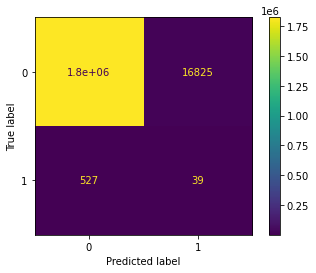

In [89]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# A graphical confusion matrix is displayed from the 'y_test' label 
# data and the 'y_pred' predicted labels using the new selected 
# features.
cm = confusion_matrix(y_test_feat, 
                      y_pred_lgbc_best, 
                      labels=lgbc_best.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=lgbc_best.classes_)
disp_cm.plot()
plt.show()

The results indicate that the LightGBM model predicted 1,737,664 true negative (accurately classified as `functional`), 498 false negative (inaccurately classified as `functional`), 68 true positive (accurately classified as `non-functional`), and 101,994 false positive (inaccurately classified as `non-functional`).  

In [90]:
# References
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

# To provide an explicit count for true negative ('tn'), false negative
# ('fn'), true positive ('tp'), and false positive ('fp') values, the 
# confusion matrix ('cm') is sliced and the values are printed.
tn = cm[0][0]
print("True negative: ", tn)
fn = cm[1][0]
print("False negative: ", fn)
tp = cm[1][1]
print("True positive: ", tp)
fp = cm[0][1]
print("False positive: ", fp)

True negative:  1822833
False negative:  527
True positive:  39
False positive:  16825


The classification report indicates zero precision and very low recall metrics for the `non-functional` class.  

In [91]:
target_names = ['functional', 'non-functional']
print("LGBMClassifier classification report: ")
print(classification_report(y_test_feat, y_pred_lgbc_best, 
                            target_names=target_names))

LGBMClassifier classification report: 
                precision    recall  f1-score   support

    functional       1.00      0.99      1.00   1839658
non-functional       0.00      0.07      0.00       566

      accuracy                           0.99   1840224
     macro avg       0.50      0.53      0.50   1840224
  weighted avg       1.00      0.99      0.99   1840224



Overall, the LightGBM classifier did not perform well. The LightGBM classifer performed very poorly compared to the random forest classifier. The default parameters actually performed better than the best parameters identified by BayesSearchCV.  

LGBMClassifier default parameters performance:  
Accuracy score: 1.000  
F1 score: 0.240  
F2 score: 0.236  

LGBMClassifier best parameters performance:  
Accuracy score: 0.944  
F1 score: 0.001  
F2 score: 0.003  

## CatBoost Classifier    

### Default  

A CatBoost classifier model is created with default parameters to determine the performance by evaluating F1 and F2 scores.  

In [92]:
# References
# https://catboost.ai/en/docs/references/training-parameters/

# A CatBoost classifier ('CatBoostClassifier') estimator is created
# with evaluation metrics (scoring) of 'F1', random state of '42', and 
# verbose to 'False' to suppress the learn status.  All other 
# parameters are default.
cbc = CatBoostClassifier(
    eval_metric='F1', 
    random_state=42, 
    verbose=False,
    thread_count=14
)

The CatBoost classifier estimator with the default parameters are fit on the `X_train` and `y_train` data with the selected features.  

In [93]:
# The CatBoost classifier ('CatBoostClassifier') estimator is fitted on
# the 'X_train' and 'y_train' data with the selected features.
cbc.fit(
    X_train_feat, 
    y_train_feat
)

The CatBoost classifier model predicts on the `X_test` data with the select features.  

In [94]:
# Predict is called on the 'X_test' data with the selected features.
y_pred_cbc = cbc.predict(X_test_feat)

In [95]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# Scores are printed for accuracy, F1-score, and F2-score.
print("CatBoostClassifier default parameters performance:")
print(f"Accuracy score: {accuracy_score(y_test_feat, y_pred_cbc):.3f}")
print(f"F1 score: {f1_score(y_test_feat, y_pred_cbc):.3f}")
print(f"F2 score: {fbeta_score(y_test_feat, y_pred_cbc, average='binary', beta=2.0):.3f}")

CatBoostClassifier default parameters performance:
Accuracy score: 1.000
F1 score: 0.731
F2 score: 0.650


### Parameter grid  

In an effort to improve the F1 and F2 scores, a grid is created with various parameters to search through to find the optimal parameters.   

In [96]:
# A CatBoost classifier ('CatBoostClassifier') estimator ('cbc_tune') 
# is created for tuning. 
cbc_tune = CatBoostClassifier()

In [97]:
# References
# https://catboost.ai/en/docs/references/training-parameters/
# https://catboost.ai/en/docs/references/training-parameters/common
# # https://towardsdatascience.com/catboost-vs-lightgbm-vs-xgboost-c80f40662924

# A paramter grid ('cbc_param_grid') to search for the best parameters 
# for the CatBoost classifier estimator ('cbc_tune') is created.
cbc_param_grid = {
    'custom_metric': ['F1', 'Precision', 'Recall'],
    'eval_metric': ['F1'], 
    'iterations': [100, 500, 1000],
    'learning_rate': [0.1, 0.3, 0.5],
    'random_seed': [42],
    'max_depth': [3, 6, 9],
    'logging_level': ['Silent'],
    'thread_count': [14],
    'task_type': ['CPU']
}

### BayesSearchCV

Using BayesSearchCV with RepeatedStratifiedKFold the parameters are searched and evaluated to find the best parameters.  

In [98]:
# References
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

# A BayesSearchCV object ('cbc_opt') is created to search the parameter 
# grid ('cbc_param_grid') for the best parameters with the CatBoost 
# classifier estimator ('cbc_tune'). The scoring is set to 'f1', '5' 
# parameter samples, '1' number of jobs, and a random state of '42'. 
# (Stratified)KFold of 3 is used for cross-validation.
cbc_opt = (
    BayesSearchCV(
        cbc_tune, cbc_param_grid, n_iter=5, 
        scoring='f1', n_jobs=1, refit=True, 
        cv=3, random_state=42)
)

In [99]:
# The parameters of the BayesSearchCV object ('cbc_opt') are 
# displayed.
cbc_opt.get_params()

{'cv': 3,
 'error_score': 'raise',
 'estimator': <catboost.core.CatBoostClassifier at 0x7f6a900bc0d0>,
 'fit_params': None,
 'iid': 'deprecated',
 'n_iter': 5,
 'n_jobs': 1,
 'n_points': 1,
 'optimizer_kwargs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': 42,
 'refit': True,
 'return_train_score': False,
 'scoring': 'f1',
 'search_spaces': {'custom_metric': ['F1', 'Precision', 'Recall'],
  'eval_metric': ['F1'],
  'iterations': [100, 500, 1000],
  'learning_rate': [0.1, 0.3, 0.5],
  'random_seed': [42],
  'max_depth': [3, 6, 9],
  'logging_level': ['Silent'],
  'thread_count': [14],
  'task_type': ['CPU']},
 'verbose': 0}

The BayesSearchCV is implemented with the CatBoost classifier estimator and fit on the `X_train` and `y_train` data with the selected features to search for the best parameters.  

In [100]:
# The BayesSearchCV object ('cbc_opt') is fitted on the 'X_train' and 
# 'y_train' resampled data with the selected features.
cbc_opt.fit(
    X_train_res_feat, 
    y_train_res_feat
)

BayesSearchCV(cv=3,
              estimator=<catboost.core.CatBoostClassifier object at 0x7f6a900bc0d0>,
              n_iter=5, random_state=42, scoring='f1',
              search_spaces={'custom_metric': ['F1', 'Precision', 'Recall'],
                             'eval_metric': ['F1'],
                             'iterations': [100, 500, 1000],
                             'learning_rate': [0.1, 0.3, 0.5],
                             'logging_level': ['Silent'],
                             'max_depth': [3, 6, 9], 'random_seed': [42],
                             'task_type': ['CPU'], 'thread_count': [14]})

In [101]:
# Best estimator, best score, and best parameters are printed.
print("CatBoostClassifier BayesSearchCV results: " )
print("Best estimator: ", cbc_opt.best_estimator_)
print("Best score: ", cbc_opt.best_score_)
print("Best parameters: ", cbc_opt.best_params_)

CatBoostClassifier BayesSearchCV results: 
Best estimator:  <catboost.core.CatBoostClassifier object at 0x7f6a900cdfd0>
Best score:  0.9981763014879634
Best parameters:  OrderedDict([('custom_metric', 'Precision'), ('eval_metric', 'F1'), ('iterations', 1000), ('learning_rate', 0.3), ('logging_level', 'Silent'), ('max_depth', 6), ('random_seed', 42), ('task_type', 'CPU'), ('thread_count', 14)])


### Best estimator

The best parameters from the BayesSearchCV parameter search are used to create a LightGBM classifier estimator.  

In [102]:
# The CatBoost classifier ('CatBoostClassifier') estimator 
# ('cgbc_best') is created using the best parameters.
# The 'scale_pos_weight' parameter is added due to the extreme class
# imbalance.
cbc_best = CatBoostClassifier(
    custom_metric='Precision',
    eval_metric='F1',
    iterations=1000,
    learning_rate=0.3,
    logging_level='Silent',
    max_depth=6,
    random_seed=42,
    task_type='CPU',
    thread_count=14,
    scale_pos_weight=scale_pos_weight
)

In [103]:
# The parameters of the CatBoost classifier ('CatBoostClassifier') 
# estimator ('cbc_best') are displayed.
cbc_best.get_params()

{'iterations': 1000,
 'learning_rate': 0.3,
 'thread_count': 14,
 'random_seed': 42,
 'logging_level': 'Silent',
 'custom_metric': 'Precision',
 'eval_metric': 'F1',
 'task_type': 'CPU',
 'max_depth': 6,
 'scale_pos_weight': 57.0}

### Fit and predict with best estimator

The CatBoost classifier estimator with the best parameters from the BayesSearchCV parameter search are fit on the `X_train` and `y_train` data with the selected features.  

In [104]:
# The best parameters are utilized with CatBoost classifier 
# ('CatBoostClassifier') estimator ('cbc_best') and fitted on the 
# 'X_train' and 'y_train' data with the selected features.
cbc_best.fit(
    X_train_feat, 
    y_train_feat
)

The CatBoost classifier model predicts on the `X_test` data with the select features.  

In [105]:
# Predict is called on the 'X_test' data with the selected features.
y_pred_cbc_best = cbc_best.predict(X_test_feat)

In [106]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# Scores are printed for accuracy, F1-score, and F2-score.
print("CatBoostClassifier best parameters performance: ")
print(f"Accuracy score: {accuracy_score(y_test_feat, y_pred_cbc_best):.3f}")
print(f"F1 score: {f1_score(y_test_feat, y_pred_cbc_best):.3f}")
print(f"F2 score: {fbeta_score(y_test_feat, y_pred_cbc_best, average='binary', beta=2.0):.3f}")

CatBoostClassifier best parameters performance: 
Accuracy score: 1.000
F1 score: 0.760
F2 score: 0.836


In [107]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# A confusion matrix is created from the 'y_test' label data and the 
# 'y_pred' predicted labels.
print("CatBoostClassifier confusion matrix: ")
print(confusion_matrix(y_test_feat, y_pred_cbc_best))

CatBoostClassifier confusion matrix: 
[[1839397     261]
 [     59     507]]


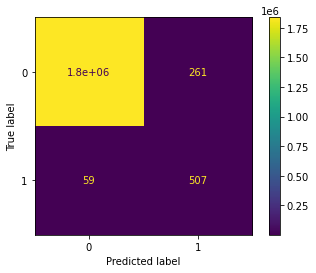

In [108]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# A graphical confusion matrix is displayed from the 'y_test' label 
# data and the 'y_pred' predicted labels using the new selected 
# features.
cm = confusion_matrix(y_test_feat, 
                      y_pred_cbc_best, 
                      labels=cbc_best.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=cbc_best.classes_)
disp_cm.plot()
plt.show()

The results indicate that the CatBoost model predicted 1,839,397 true negative (accurately classified as `functional`), 59 false negative (inaccurately classified as `functional`), 507 true positive (accurately classified as `non-functional`), and 261 false positive (inaccurately classified as `non-functional`).  

In [109]:
# References
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

# To provide an explicit count for true negative ('tn'), false negative
# ('fn'), true positive ('tp'), and false positive ('fp') values, the 
# confusion matrix ('cm') is sliced and the values are printed.
tn = cm[0][0]
print("True negative: ", tn)
fn = cm[1][0]
print("False negative: ", fn)
tp = cm[1][1]
print("True positive: ", tp)
fp = cm[0][1]
print("False positive: ", fp)

True negative:  1839397
False negative:  59
True positive:  507
False positive:  261


The classification report indicates low precision and higher recall metrics for the `non-functional` class.    

In [110]:
target_names = ['functional', 'non-functional']
print("CatBoostClassifier classification report: ")
print(classification_report(y_test_feat, y_pred_cbc_best, 
                            target_names=target_names))

CatBoostClassifier classification report: 
                precision    recall  f1-score   support

    functional       1.00      1.00      1.00   1839658
non-functional       0.66      0.90      0.76       566

      accuracy                           1.00   1840224
     macro avg       0.83      0.95      0.88   1840224
  weighted avg       1.00      1.00      1.00   1840224



The CatBoost classifier performed better than the random forest classifier and significantly better than the LightGBM classifier.  The best parameters identified by BayesSearchCV performed better than the default parameters.  

CatBoostClassifier default parameters performance:  
Accuracy score: 1.000  
F1 score: 0.731  
F2 score: 0.650   

CatBoostClassifier best parameters performance:  
Accuracy score: 1.000  
F1 score: 0.760  
F2 score: 0.836  

## XGBoost classifier

A XGBoost classifier model is created with default parameters to determine the performance by evaluating F1 and F2 scores.  

### Default

In [111]:
# References
# https://xgboost.readthedocs.io/en/stable/python/python_api.html

# A XGBoost classifier ('XGBClassifier') estimator is created
# random state of '42'.  XGBClassifier does not have a evaluation 
# metric for 'F1'. The 'F1' score will be evaluated during 
# BayesSearchCV. All other parameters are default.
xgbc = xgb.XGBClassifier(
    n_jobs=14,
    random_state=42
)

The XGBoost classifier estimator with the default parameters are fit on the `X_train` and `y_train` data with the selected features.  

In [112]:
# The XGBoost classifier ('XGBClassifier') estimator is fitted on
# the 'X_train' and 'y_train' data with the selected features.
xgbc.fit(
    X_train_feat, 
    y_train_feat
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=14, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

The XGBoost classifier model predicts on the `X_test` data with the select features.  

In [113]:
# Predict is called ont he 'X_test' data with the selected features.
y_pred_xgbc = xgbc.predict(X_test_feat)

In [114]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# Scores are printed for accuracy, F1-score, and F2-score.
print("XGBClassifier default parameters performance:")
print(f"Accuracy score: {accuracy_score(y_test_feat, y_pred_xgbc):.3f}")
print(f"F1 score: {f1_score(y_test_feat, y_pred_xgbc):.3f}")
print(f"F2 score: {fbeta_score(y_test_feat, y_pred_xgbc, average='binary', beta=2.0):.3f}")

XGBClassifier default parameters performance:
Accuracy score: 1.000
F1 score: 0.518
F2 score: 0.408


### Parameter grid  

In an effort to improve the F1 and F2 scores, a grid is created with various parameters to search through to find the optimal parameters.  

In [115]:
# The XGBoost classifier ('XGBClassifier') estimator ('xgbc_tune') 
# is created for tuning.
xgbc_tune = xgb.XGBClassifier()

In [116]:
# The parameters of the XGBoost classifier ('XGBClassifier') estimator 
# ('xgbc_tune') are displayed.
xgbc_tune.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [117]:
# References
# https://xgboost.readthedocs.io/en/stable/parameter.html
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# https://towardsdatascience.com/catboost-vs-lightgbm-vs-xgboost-c80f40662924

xgbc_param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3, 0.5],
    'random_state': [42],
    'n_jobs': [14]
}

### BayesSearchCV

Using BayesSearchCV with RepeatedStratifiedKFold the parameters are searched and evaluated to find the best parameters.  

In [118]:
# References
# https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

# A BayesSearchCV object ('xgbc_opt') is created to search the 
# parameter grid ('xgbc_param_grid') for the best parameters with the 
# LightGBM classifier estimator ('xgbc_tune'). The scoring is set to 
# 'f1', '5' parameter samples, '1' number of jobs, and a random state 
# of '42'. (Stratified)KFold of 3 is used for cross-validation.
xgbc_opt = (
    BayesSearchCV(
        xgbc_tune, xgbc_param_grid, n_iter=5, 
        scoring='f1', n_jobs=1, refit=True, 
        cv=3, random_state=42)
)

In [119]:
# The parameters of the BayesSearchCV object ('xgbc_opt') are 
# displayed.
xgbc_opt.get_params()

{'cv': 3,
 'error_score': 'raise',
 'estimator__objective': 'binary:logistic',
 'estimator__use_label_encoder': False,
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__num

The BayesSearchCV is implemented with the XGBoost classifier estimator and fit on the `X_train` and `y_train` data with the selected features to search for the best parameters.  

In [120]:
# The BayesSearchCV object ('xgbc_opt') is fitted on the 'X_train' and 
# 'y_train' resampled data with the selected features.
xgbc_opt.fit(
    X_train_res_feat, 
    y_train_res_feat
)

BayesSearchCV(cv=3,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, gamma=None, gpu_id=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_bin=None,
                                      max_c...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, reg_alpha=None,
                                      reg_lambda=None, ...),
              n_iter=5, random_state=42, scoring='f1',
              search_spaces={'learning_rate': [0.1, 0.3, 0.5],
                             'max_depth': [3, 6, 9],
                             'n_estimators': [100, 500, 1000], 'n_jobs': [14],
                             'random_state': [42]})

In [121]:
# Best estimator, best score, and best parameters are printed.
print("XGBClassifier BayesSearchCV results: " )
print("Best estimator: ", xgbc_opt.best_estimator_)
print("Best score: ", xgbc_opt.best_score_)
print("Best parameters: ", xgbc_opt.best_params_)

XGBClassifier BayesSearchCV results: 
Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=14, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)
Best score:  0.9997921246932945
Best parameters:  OrderedDict([('learning_rate', 0.5), ('max_depth', 9), ('n_estimators', 500), ('n_jobs', 14), ('random_state', 42)])


### Best estimator

The best parameters from the BayesSearchCV parameter search are used to create a XGBoost classifier estimator.  

In [122]:
# The XGBoost classifier ('XGBClassifier') estimator ('xgbc_best') 
# is created using the best parameters. 
# The 'scale_pos_weight' parameter is added due to the extreme class
# imbalance.  
xgbc_best = xgb.XGBClassifier(
    learning_rate=0.5,
    max_depth=9,
    n_estimators=500,
    scale_pos_weight=scale_pos_weight,
    n_jobs=14,
    random_state=42)

In [123]:
# The parameters of the XGBoost classifier ('XGBClassifier') 
# estimator ('xgbc_best') are displayed.
xgbc_best.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 9,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 500,
 'n_jobs': 14,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 57.0,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Fit and predict with best estimator  

The XGBoost classifier estimator with the best parameters from the BayesSearchCV parameter search are fit on the `X_train` and `y_train` data with the selected features.  

In [124]:
# The best parameters are utilized with XGBoost classifier 
# ('XGBClassifier') estimator ('xgbc_best') and fitted on the 
# 'X_train' and 'y_train' data with the selected features.
xgbc_best.fit(
    X_train_feat, 
    y_train_feat
)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=14, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

The XGBoost classifier model predicts on the `X_test` data with the select features.  

In [125]:
# Predict is called on the 'X_test' data with the selected features.
y_pred_xgbc_best = xgbc_best.predict(X_test_feat)

In [126]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

# Scores are printed for accuracy, F1-score, and F2-score.
print("XGBClassifier best parameters performance: ")
print(f"Accuracy score: {accuracy_score(y_test_feat, y_pred_xgbc_best):.3f}")
print(f"F1 score: {f1_score(y_test_feat, y_pred_xgbc_best):.3f}")
print(f"F2 score: {fbeta_score(y_test_feat, y_pred_xgbc_best, average='binary', beta=2.0):.3f}")

XGBClassifier best parameters performance: 
Accuracy score: 1.000
F1 score: 0.810
F2 score: 0.806


In [127]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

# A confusion matrix is created from the 'y_test' label data and the 
# 'y_pred' predicted labels.
print("XGBClassifier confusion matrix: ")
print(confusion_matrix(y_test_feat, y_pred_xgbc_best))

XGBClassifier confusion matrix: 
[[1839556     102]
 [    111     455]]


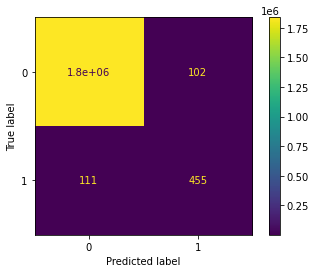

In [128]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# A graphical confusion matrix is displayed from the 'y_test' label 
# data and the 'y_pred' predicted labels using the new selected 
# features.
cm = confusion_matrix(y_test_feat, 
                      y_pred_xgbc_best, 
                      labels=xgbc_best.classes_)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=xgbc_best.classes_)
disp_cm.plot()
plt.show()

The results indicate that the XGBoost model predicted 1,839,556 true negative (accurately classified as `functional`), 111 false negative (inaccurately classified as `functional`), 455 true positive (accurately classified as `non-functional`), and 102 false positive (inaccurately classified as `non-functional`).  

In [129]:
# References
# https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal

# To provide an explicit count for true negative ('tn'), false negative
# ('fn'), true positive ('tp'), and false positive ('fp') values, the 
# confusion matrix ('cm') is sliced and the values are printed.
tn = cm[0][0]
print("True negative: ", tn)
fn = cm[1][0]
print("False negative: ", fn)
tp = cm[1][1]
print("True positive: ", tp)
fp = cm[0][1]
print("False positive: ", fp)

True negative:  1839556
False negative:  111
True positive:  455
False positive:  102


The classification report indicates very comparable precision and recall metrics for the `non-functional` class.    

In [130]:
target_names = ['functional', 'non-functional']
print("XGBClassifier classification report: ")
print(classification_report(y_test_feat, y_pred_xgbc_best, 
                            target_names=target_names))

XGBClassifier classification report: 
                precision    recall  f1-score   support

    functional       1.00      1.00      1.00   1839658
non-functional       0.82      0.80      0.81       566

      accuracy                           1.00   1840224
     macro avg       0.91      0.90      0.91   1840224
  weighted avg       1.00      1.00      1.00   1840224



The XGBoost classifier with defualt parameters did not perform better than the random forest classifier. The XGBoost classifier with tuned parameters performed better than the random forest classifier and the CatBoost classifer (for F1-score). The XGBoost classifer signficantly performed better than the LightGBM classifier. The best parameters identified by BayesSearchCV performed substantially better than the default parameters.  

XGBClassifier default parameters performance:  
Accuracy score: 1.000  
F1 score: 0.518  
F2 score: 0.408  

XGBClassifier best parameters performance:  
Accuracy score: 1.000  
F1 score: 0.810  
F2 score: 0.806  

## Summary  

The notebook examined three gradient boosted classifier models including LightGBM, CatBoost, and XGBoost to determine if a hard drive failure could be accurately classified. Prior to examining the models, the label encoding was applied to the categorical features. To find the best features, three feature selection techniques were utilized including SelectKBest, random forest feature importance, and SelectByShuffling. An ensemble of the top ten features were considered from each technique and eleven features were selected. To address the class imbalance and provide a subset of data for hyperparameter tuning, random sampling (over and under) was implemented. A baseline was established using a random forest classifier with default parameters. The three gradient boosted classifier models with default parameters were invoked and measured for accuracy, F1-score, F2-score. In an attempt to improve metrics, BayesSearchCV was engaged to perform hyperparameter tuning. In addition, the `scale_pos_weight` parameter was used with the gradient boosted models to offset the extreme class imbalance.  

In conclusion, the random forest classifier with default parameters performed moderately as a baseline. LightGBM performed poorly. In fact, tuning the LightGBM classifier only made the model worse. The CatBoost classifier with default parameters performed almost identically to the random forest classifier. However, tuning the CatBoost classifier slightly improved the model.  The XGBoost classifier with default parameters performed worse than the random forest classifier. However, tuning the XGBoost classifier improved the model to perform better than the random forest classifier and the CatBoost classifier (with the exception of the F2-score in the CatBoost classifier with tuned parameters). Overall, XGBoost with tuned parameters had the highest F1 score and CatBoost with tuned parameters had the highest F2 score.   


|     MODEL                                                    |     ACCURACY    |       F1     |       F2     |
|--------------------------------------------------------------|:---------------:|:------------:|:------------:|
|     Random forest classifier (default; selected features)    |       100%      |     0.727    |     0.635    |
|     LightGBM classifier (default; selected features)         |       100%      |     0.240    |     0.236    |
|     LightGBM classifier (tuned; selected features)           |       94.4%     |     0.001    |     0.003    |
|     CatBoost classifier (default; selected features)         |       100%      |     0.731    |     0.650    |
|     CatBoost classifier (tuned; selected features)           |       100%      |     0.760    |     0.836    |
|     XGBoost classifier (default; selected features)          |       100%      |     0.518    |     0.408    |
|     XGBoost classifier (tuned; selected features)            |       100%      |     0.810    |     0.806    |




## Final thoughts  

The large amount of data presented challenges with tuning the models. Random sampling (over and under) provided an adequate option to use a smaller subset of data for feature selection and for tuning. Random under-sampling alone did not produce enough samples to be viable. 

For hyperparameter tuning, GridSearchCV proved to be complex even with the sampled data. RandomSearchCV did not seem to identify optimal parameters. Perhaps, RandomSearchCV was too random in the selection of hyperparameters. Instead, BayesSearchCV provided to a nice compromise of speed and accuracy. Credit to user20160 on Cross Validated for the suggestion.  

The random forest classifier with default parameters served as an acceptable baseline to measure gradient boosted models.  

The LightGBM classifier performed surprisingly poorly. However, CatBoost and XGBoost classifiers with tuned features demonstrated improvements over the random forest classifier.  

## Next steps  

Next steps could include experimentation with deteriorating windows sizes. Early on in the project, a window with a deteriorating window of 3 days was tested but did not show significant improvements. However, the project evolved, improved, and might benefit from reexamining the deteriorating window sizes.  

Narrowing the data down to a specific group of hard drive models and capacities (i.e., ST12000NMxxxx) might provide better results. These hard drive models and capacities might share more common attributes and characteristics. Again, early on the project, one model was selected but the results did not suggest substantial improvements. Selecting a group of hard drive models might be valuable to revisit, since refinements were made to the project.  

Another step could include investigating additional sampling techniques. Initially, SMOTE was evaluated, but a decision was made not to use synthetic data. Perhaps, SMOTE might produce better sample variations.  

With the exception of the LightGBM classifier, improvements were observed with hyperparameter tuning. During hyperparameter tuning, a coarse grid (not having too many hyperparameters) was used. Expanding the grid search proved to be very time consuming, resulting in hours for the search. In addition, for consistency, similar hyperparameters were used on all the gradient boosted models. If given hours or days to run, expanding the grid to search might find better hyperparameters and improve the models. Furthermore, libraries such as Hyperopt or Optuna may identify more optimal hyperparameters.

Lastly, there might be opportuning for further improvement by testing machine learning libraries suited for larger data, such as Spark MLlib or TensorFlow Keras Decision Trees (Yggdrasil) (Abuzaid et al., 2016).  

## <center>References</center>  

Abuzaid, F., Bradley, J.,Liang, F., Feng, A., Yang, L., Zaharia, M., & Talwalkar, A. (2016). Yggdrasil: An optimized system for training deep decision trees at scale. <i>29th Conference on Neural Information Processing Systems.</i> https://www.cs.cmu.edu/~atalwalk/yggdrasil_nips_with_appendix.pdf  
<br>
Brownlee, J. (2020, August 21). <i>How to configure XGBoost for imbalanced classification.</i> Machine Learning Mastery. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/  
<br>
Deltascience, H. (2019, August 7). <i>What is the proper usage of scale_pos_weight in xgboost for imbalanced datasets?</i> Cross Validated. https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets  
<br>
Feature-engine developers. (2022). <i>SelectByShuffling</i>. Feature-engine API. https://feature-engine.readthedocs.io/en/latest/api_doc/selection/SelectByShuffling.html  
<br>
Google. (2022, October 5). <i>Yggdrasil Decision Forests.</i> GitHub. https://github.com/google/yggdrasil-decision-forests  
<br>
Klein, A. (2016, October 6). <i>What SMART stats tell us about hard drives.</i> Backblaze Blog.  https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/  
<br>
Mehta, H. (2017, July 13). <i>What is the proper usage of scale_pos_weight in xgboost for imbalanced datasets?</i> Cross Validated. https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets  
<br>
S.M.A.R.T. (2022, September 9). In <i>Wikipedia</i>. https://en.wikipedia.org/w/index.php?title=S.M.A.R.T.&oldid=1109378579  
<br>
Scikit-learn Developers. (2022). <i>Feature importances with a forest of trees.</i> https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html  
<br>
Scikit-learn Developers. (2022). <i>Sklearn.feature_selection.SelectKBest.</i> https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html  
<br>
Scikit-optimize contributors. (2020). <i>BayesSearchCV.</i> Scikit-optimize. https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html  
<br>
User20160. (2017, March 29). <i>How to speed up hyperparameter optimization?</i> Cross Validated. https://stats.stackexchange.com/questions/270315/how-to-speed-up-hyperparameter-optimization  